# Init

In [1]:
params = {
    "window_size": 40,
    "k": 0.06
}

In [2]:
%matplotlib inline
#%load_ext pyinstrument
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import concurrent.futures
import math
plt.rcParams['figure.dpi'] = 200

In [3]:
def show_image(img, no_convert = False):
    plt.axis("off")
    if (no_convert):
        plt.imshow(img)
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_GRAY2RGB))
    #plt.show()

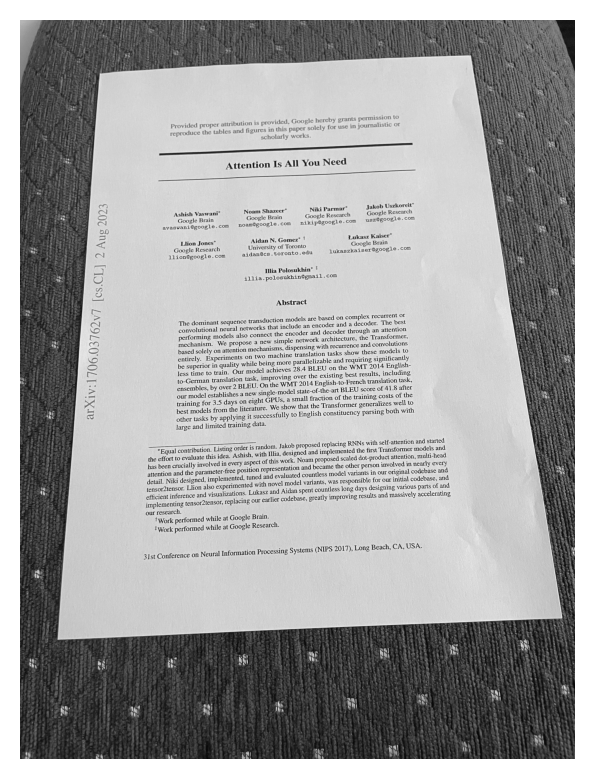

In [4]:
orig_img_bgr = cv.imread('IMG_3030.jpeg', cv.IMREAD_COLOR_BGR)
orig_img = cv.cvtColor(orig_img_bgr, cv.COLOR_BGR2GRAY)
assert orig_img is not None, "image not found"
show_image(orig_img)

# Task 1

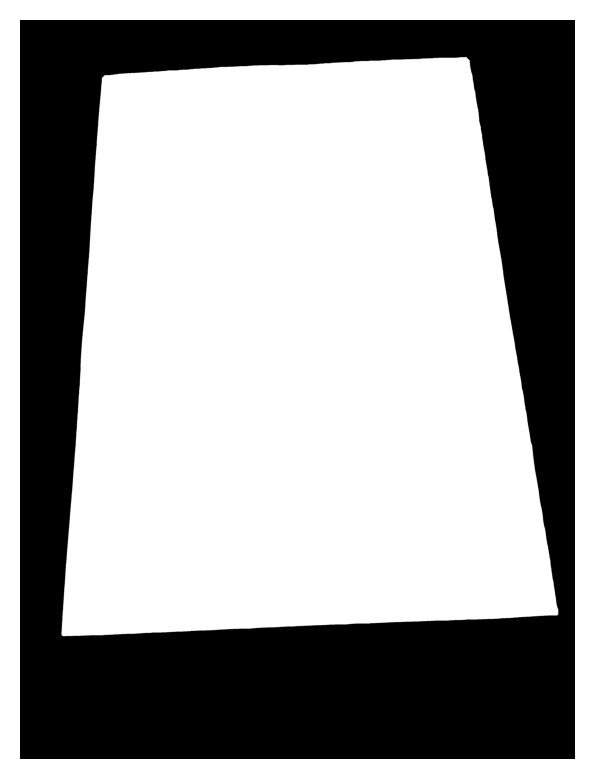

In [5]:
filtered = orig_img
filtered = cv.blur(filtered, (55, 55))
#_, filtered = cv.threshold(filtered, 150, 255, cv.THRESH_BINARY)
filtered = cv.morphologyEx(filtered, cv.MORPH_CLOSE, np.ones((5, 5), dtype=np.uint8), iterations=5)

mask = np.zeros(filtered.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,filtered.shape[1]-20,filtered.shape[0]-20)
cv.grabCut(cv.cvtColor(filtered, cv.COLOR_GRAY2BGR),mask,rect,bgdModel,fgdModel,3,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
filtered = filtered*mask2

_, filtered = cv.threshold(filtered, 128, 255, cv.THRESH_BINARY)

show_image(filtered, no_convert=False)

In [6]:
dx = cv.Sobel(filtered,cv.CV_64F,1,0,ksize=3)
dy = cv.Sobel(filtered,cv.CV_64F,0,1,ksize=3)

height, width = filtered.shape

Ixx = dx**2
Ixy = dx*dy
Iyy = dy**2

offset = params["window_size"] // 2
k = params["k"]


In [7]:

corners_img = np.zeros(filtered.shape)

with concurrent.futures.ProcessPoolExecutor() as e:
    def submit_worker(func, j):
        global Ixx, Ixy, Iyy, offset, width, k
        j_start = j - offset
        j_end = j + offset + 1
        return (func, j, Ixx[j_start:j_end], Ixy[j_start:j_end], Iyy[j_start:j_end], offset, width, k)
    def worker(j, Ixx, Ixy, Iyy, offset, width, k):
        j_start = j - offset
        j_end = j + offset + 1
        corners_img_j = np.zeros(width)
        for i in range(offset, width - offset):
            i_start = i - offset
            i_end = i + offset + 1

            sIxx = Ixx[:, i_start:i_end].sum()
            sIxy = Ixy[:, i_start:i_end].sum()
            sIyy = Iyy[:, i_start:i_end].sum()

            det = (sIxx * sIyy) - (sIxy * sIxy)
            tr = sIxx + sIyy
            corners_img_j[i] = det - k * tr * tr
        return corners_img_j
    fut = [e.submit(*submit_worker(worker, j)) for j in range(offset, height - offset)]
    for j, r in enumerate(fut):
        corners_img[j + offset] = r.result()


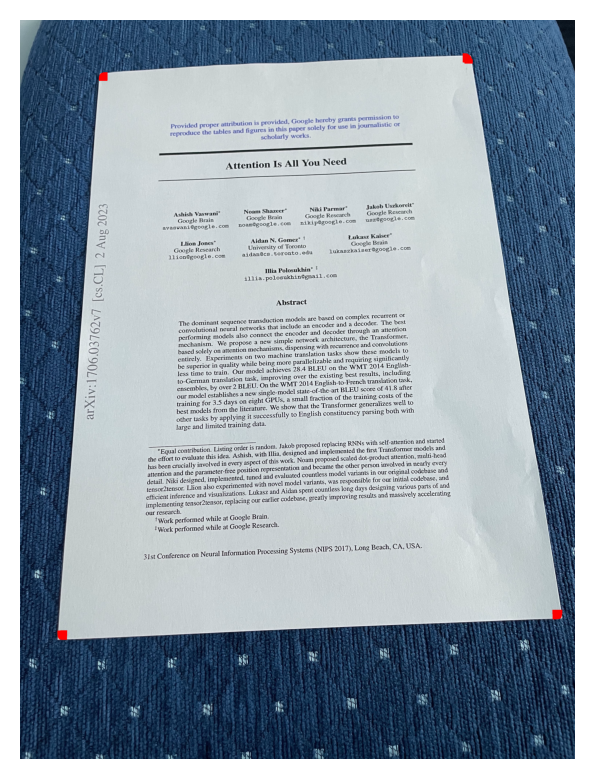

In [8]:
corners_img_threshold = corners_img >= corners_img.max() / 10
img_w_corners = np.copy(orig_img_bgr)
img_only_corners = np.array(corners_img_threshold, dtype=orig_img_bgr.dtype) * 255
corners = list(zip(*np.flip(np.nonzero(corners_img_threshold), 0)))
for c in corners:
    i, j = c
    cv.rectangle(img_w_corners, (i - 10, j - 10, 20, 20), (255, 0, 0), -1)
show_image(img_w_corners, no_convert=True)

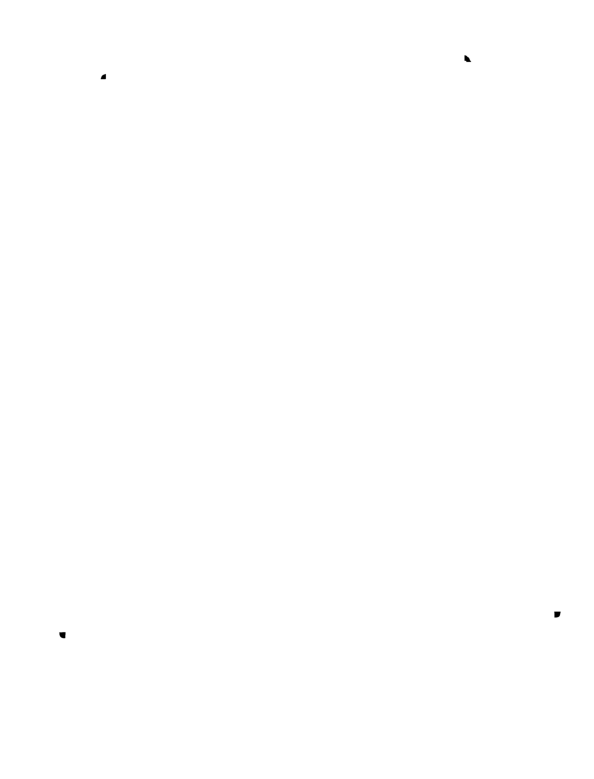

In [9]:
show_image(cv.bitwise_not(img_only_corners), no_convert=False)

## Filter corner points

[[450, 306], [2443, 209], [2938, 3254], [219, 3364]]


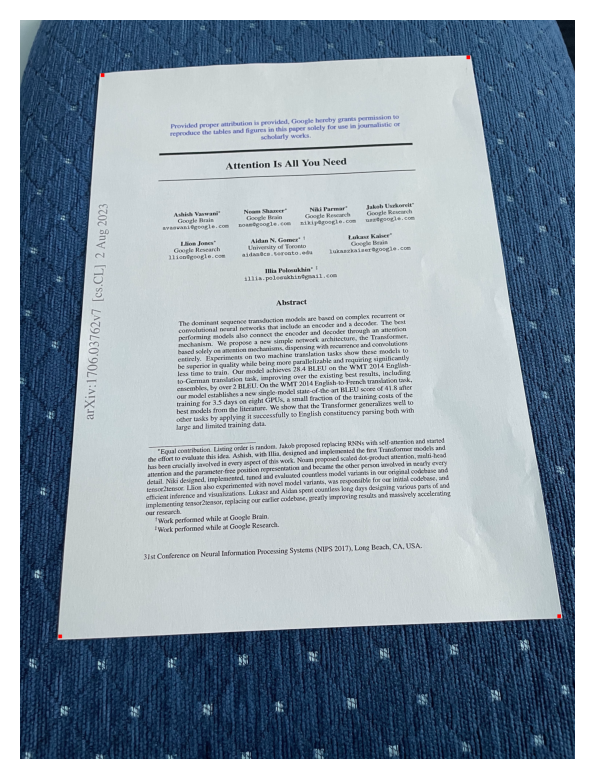

In [10]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype('int').tolist()

corners4 = order_points(corners)

print(corners4)

img_w_corners = np.copy(orig_img_bgr)
for c in corners4:
    if c is None:
        continue
    i, j = c
    cv.rectangle(img_w_corners, (i - 10, j - 10, 20, 20), (255, 0, 0), -1)
show_image(img_w_corners, no_convert=True)

In [11]:
def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)

destination_corners = find_dest(corners4)

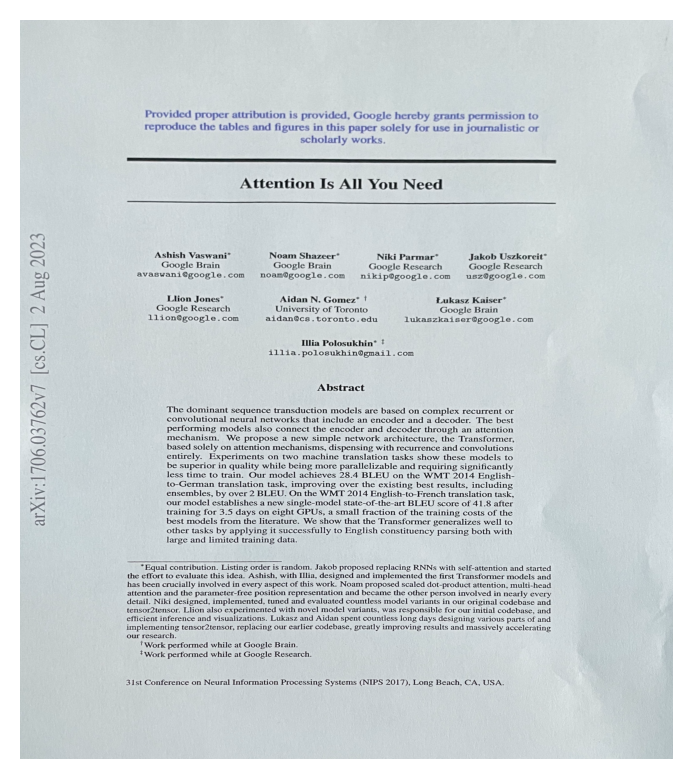

In [12]:
# Getting the homography.
M = cv.getPerspectiveTransform(np.float32(corners4), np.float32(destination_corners))
# Perspective transform using homography.
final_bgr = cv.warpPerspective(orig_img_bgr, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv.INTER_LINEAR)

show_image(final_bgr, no_convert=True)

# Task 2
## Get general text lines

In [13]:
final = cv.cvtColor(final_bgr, cv.COLOR_BGR2GRAY)

1618


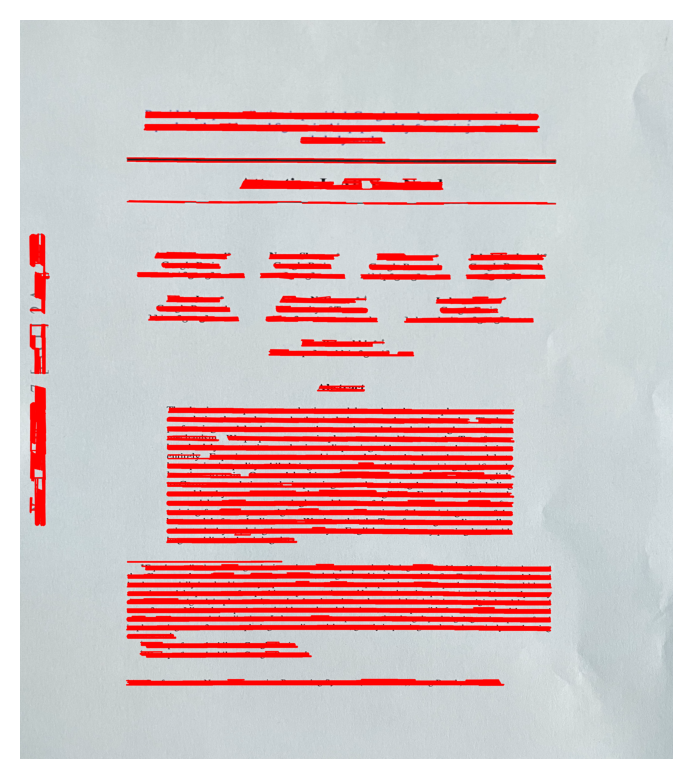

In [14]:
final_filtered = final
#_, final_filtered = cv.threshold(final_filtered, 128, 255, cv.THRESH_BINARY_INV)
final_filtered = cv.Canny(final_filtered, 50, 200)
lines = cv.HoughLinesP(final_filtered, 1, np.pi/180, 50, None, 50, 33)
img_w_contours = np.copy(final_bgr)
img_only_contours = np.zeros_like(final)
print(len(lines))
for l in lines:
    _l = l[0]
    line_width = 3
    cv.line(img_w_contours, (_l[0], _l[1]), (_l[2], _l[3]), (255, 0, 0), line_width, cv.LINE_AA)
    cv.line(img_only_contours, (_l[0], _l[1]), (_l[2], _l[3]), 255, line_width, cv.LINE_AA)
show_image(img_w_contours, no_convert=True)

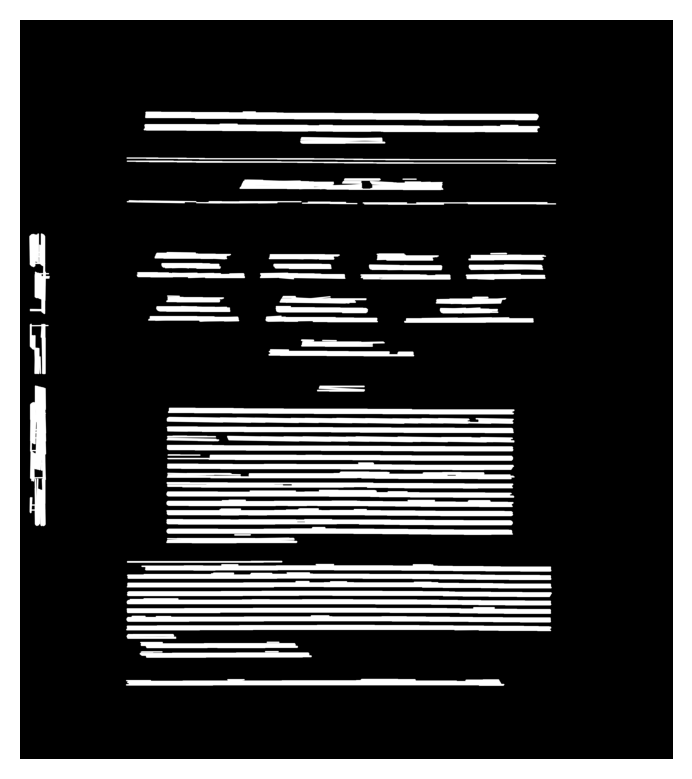

In [15]:
show_image(img_only_contours, no_convert=False)

59


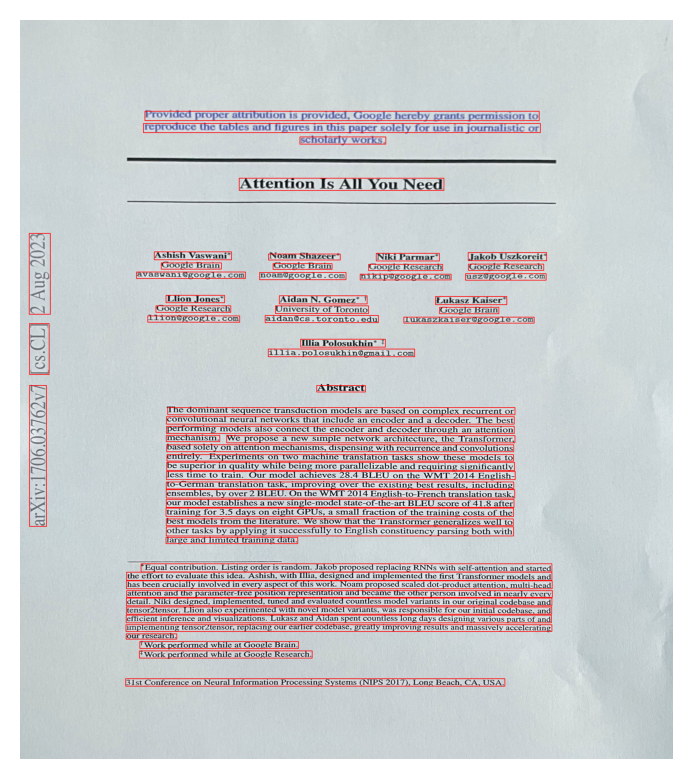

In [16]:
contours, hierarchy = cv.findContours(img_only_contours, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
boxes = []
for ctr in contours:
    x, y, w, h = cv.boundingRect(ctr)
    # get rid of random incorrect boxes and horizontal lines
    if w < 21 or h < 21:
        continue
    boxes.append([x, y, x + w, y + h])
img_w_contours = np.copy(final_bgr)
for box in boxes:
    top_left = (box[0], box[1])
    bottom_right = (box[2], box[3])
    cv.rectangle(img_w_contours, top_left, bottom_right, (255,0,0), 2)

print(len(boxes))
show_image(img_w_contours, no_convert=True)

## Count symbols

In [17]:
components = []
for box in boxes:
    final_box = final[box[1] : box[3], box[0] : box[2]]
    final_filtered = final_box
    _, final_filtered = cv.threshold(final_filtered, 128, 255, cv.THRESH_BINARY_INV)
    #_, final_filtered = cv.threshold(final_filtered, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(final_filtered, connectivity=4)
    comps = stats[1:]
    centers = centroids[1:]
    stats = stats[1:]
    components.append((box, stats))

### Count symbols by segmenting the text lines

2657


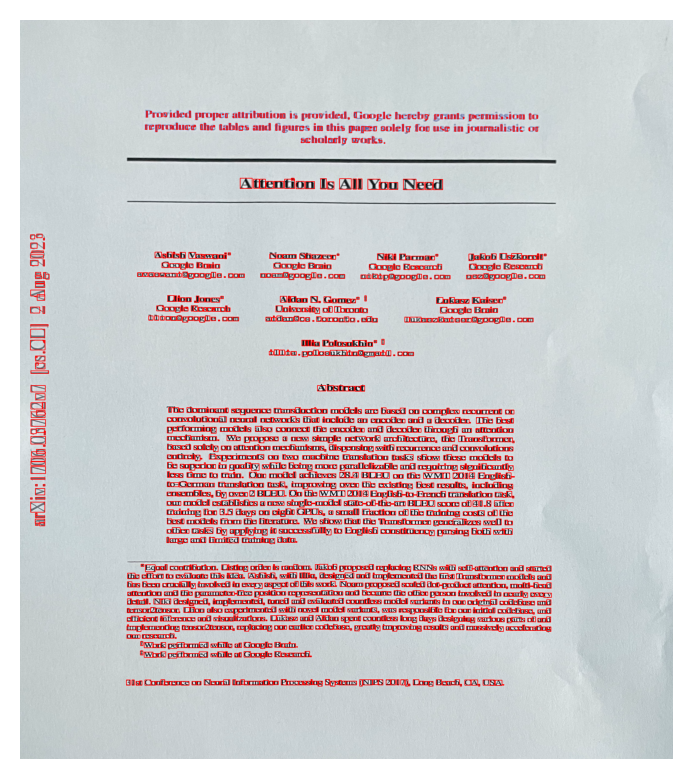

In [18]:
img_w_contours = np.copy(final_bgr)
sum = 0
for box, stats in components:
    box_x, box_y = box[0:2]
    for i in range(0, len(stats)):
        x = stats[i, cv.CC_STAT_LEFT] + box_x
        y = stats[i, cv.CC_STAT_TOP] + box_y
        w = stats[i, cv.CC_STAT_WIDTH]
        h = stats[i, cv.CC_STAT_HEIGHT]
        cv.rectangle(img_w_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)
        sum += 1
print(sum)
show_image(img_w_contours, no_convert=True)

### Count symbols without segmenting the text lines

2653


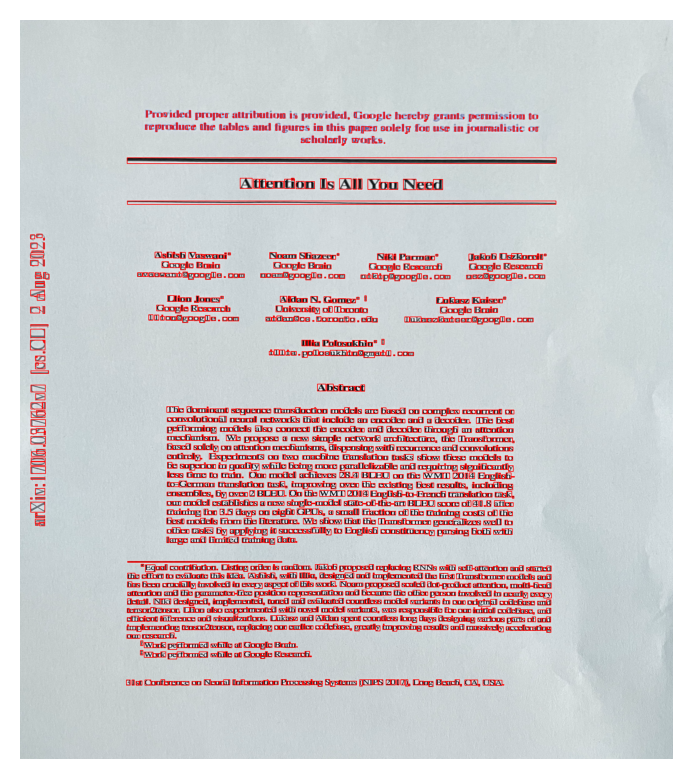

In [19]:
final_filtered = final
#_, final_filtered = cv.threshold(final_filtered, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
_, final_filtered = cv.threshold(final_filtered, 128, 255, cv.THRESH_BINARY_INV)
n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(final_filtered, connectivity=4)
comps = stats[1:]
centers = centroids[1:]
stats = stats[1:]
img_w_contours = np.copy(final_bgr)
for i in range(0, len(stats)):
    x = stats[i, cv.CC_STAT_LEFT]
    y = stats[i, cv.CC_STAT_TOP]
    w = stats[i, cv.CC_STAT_WIDTH]
    h = stats[i, cv.CC_STAT_HEIGHT]
    cv.rectangle(img_w_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)
print(len(stats))
show_image(img_w_contours, no_convert=True)

## Count actual text lines

In [20]:
boxes_hor = []
boxes_vert = []
for box in boxes:
    final_box = final[box[1] : box[3], box[0] : box[2]]
    final_filtered = final_box
    _, final_filtered = cv.threshold(final_filtered, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    is_hor = final_filtered.sum(axis=1).max() > final_filtered.sum(axis=0).max()
    if (is_hor):
        boxes_hor.append(box)
    else:
        boxes_vert.append(box)
boxes_hor.sort(key=lambda e: e[1])
boxes_vert.sort(key=lambda e: e[0])
print(len(boxes_hor), len(boxes_vert))

56 3


In [21]:
height, width = final.shape
boxes_hor_lines = []
tmp_y = -height
boxes_vert_lines = []
tmp_x = -width
for box in boxes_hor:
    if abs(box[1] <= tmp_y <= box[3]):
        boxes_hor_lines[-1].append(box)
    else:
        boxes_hor_lines.append([box])
        tmp_y = box[1] + (box[3] - box[1]) * 0.5
for box in boxes_vert:
    if abs(box[0] <= tmp_x <= box[2]):
        boxes_vert_lines[-1].append(box)
    else:
        boxes_vert_lines.append([box])
        tmp_x = box[0] + (box[2] - box[0]) * 0.5
print(len(boxes_hor_lines), len(boxes_vert_lines), len(boxes_hor_lines) + len(boxes_vert_lines))

40 1 41


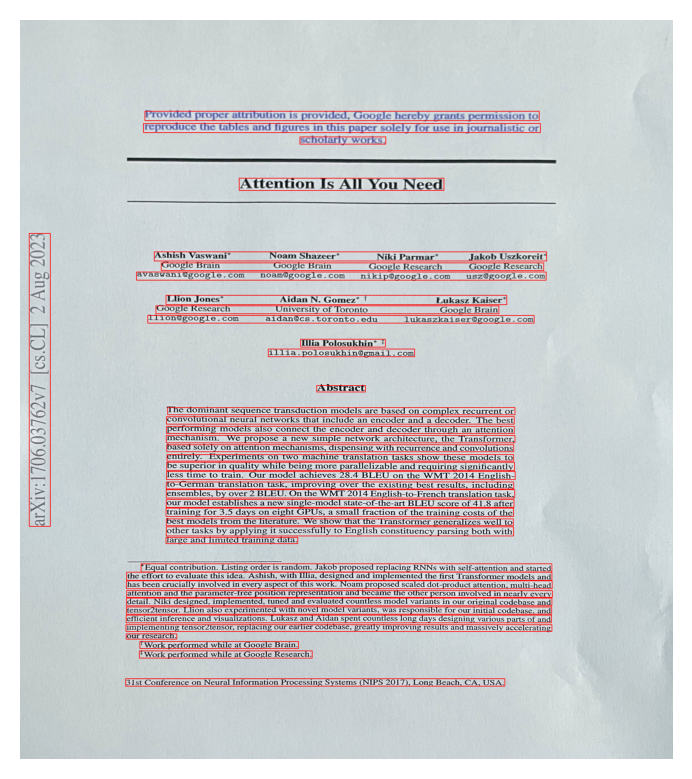

In [22]:
boxes_hor_lines_all = []
boxes_vert_lines_all = []
img_w_contours = np.copy(final_bgr)
for box in boxes_hor_lines:
    b = [min(box, key=lambda x: x[0])[0], min(box, key=lambda x: x[1])[1], max(box, key=lambda x: x[2])[2], max(box, key=lambda x: x[3])[3]]
    boxes_hor_lines_all.append(b)
    top_left = (b[0], b[1])
    bottom_right = (b[2], b[3])
    cv.rectangle(img_w_contours, top_left, bottom_right, (255,0,0), 2)
for box in boxes_vert_lines:
    b = [min(box, key=lambda x: x[0])[0], min(box, key=lambda x: x[1])[1], max(box, key=lambda x: x[2])[2], max(box, key=lambda x: x[3])[3]]
    boxes_vert_lines_all.append(b)
    top_left = (b[0], b[1])
    bottom_right = (b[2], b[3])
    cv.rectangle(img_w_contours, top_left, bottom_right, (255,0,0), 2)
show_image(img_w_contours, no_convert=True)